## What is Paper Replication?

Machine Learning is advancing fast, and every day a lot of scientific papers is written for it. By **Paper Replicating** we are taking advantage those papers and convert them into code, to help us solve out problems.

For example, let's say a new model architecture gets released that performs better than any other architecture before on various benchmarks, wouldn't it be nice to try that architecture on your own problems?

## What is a ML Research Paper?

A ML research paper is a scientific paper that details findings on a specific area.

Each **Research Paper** obey this general structure:
* `Abstract`: An overview/summary of the paper's main findings/contributions.
* `Introduction`: What's the paper's main problem and details of previous methods used to try and solve it.
* `Method`: How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used?
* `Results`: 	What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works? (this is where experiment tracking comes in handy)
* `Conclusion`: 	What are the limitations of the suggested methods? What are some next steps for the research community?
* `References`: What resources/other papers did the researchers look at to build their own body of work?
* `Appendix`: Are there any extra resources/findings to look at that weren't included in any of the above sections?

## Why bother Replicating ML Papers?

Other than the obvious of taking something that is proven to work, by going through the process of replication we are gaining skills and knowledge and also paracticing our existing skills.

## Where to Find Those Papers?

* `arXiv`: Pronounced "archive", arXiv is a free and open resource for reading technical articles on everything from physics to computer science (inlcuding machine learning).
* `AK Twitter`: The AK Twitter account publishes machine learning research highlights, often with live demos almost every day.
* `Papers with Code`: A curated collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.

## Getting Started

The paper we are going to replicate is: https://arxiv.org/abs/2010.11929 and it's based on the `Transformer Architecture`.

A Transformer architecture is generally considered to be any neural network that uses the [attention mechanism](https://en.wikipedia.org/wiki/Attention_(machine_learning)) as its primary learning layer. Similar to a how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

The problem we are about to handle is how to use this architecture to imporve the accuracy of the Food-Mini Dataset.

Because we are going to adapt the **Transformer Archirecture** on a computer vision problem, the architecture that we'll use is called `Vision Transformer (ViT) Architecture`

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, models

import matplotlib.pyplot as plt

In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
from drive.MyDrive.going_modular.going_modular import data_setup, engine

In [ ]:
from pathlib import Path

## Setting up Deafult Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## Loading the Dataset and Setting Training and Testing Paths

In [ ]:
dataset_path = Path("/content/drive/MyDrive/going_modular/data/pizza_steak_sushi")

train_path = dataset_path / "train"
test_path = dataset_path / "test"

print(train_path)
print(test_path)

/content/drive/MyDrive/going_modular/data/pizza_steak_sushi/train
/content/drive/MyDrive/going_modular/data/pizza_steak_sushi/test


## Creating the Transformations of the Paper

In [ ]:
# We can see that the image size (that the paper implies) is 224
IMAGE_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

## Creating the Data Loaders


The paper implies a Batch Size of 4096, but we will stick to 32, because some machines (like Google Colab) might not be able to handle 4096 images on GPU at a time.

In [ ]:
BATCH_SIZE = 32

train_dl, test_dl, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                               test_dir=test_path,
                                                               train_transform=manual_transforms,
                                                               test_transform=manual_transforms,
                                                               batch_size=BATCH_SIZE)
print(len(train_dl), len(test_dl))
print(class_names)

8 3
['pizza', 'steak', 'sushi']


## Understanding the ViT Architecture

- ViT is a deep learning neural network architecture that is comprised of `layers`. A collection of layers is often referred to as a `block`. Stacking many blocks together is what gives us the whole `architecture`.

- We are going to analyze the ViT layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

- The main three resources (inside the paper) we'll be looking at for the architecture design are:
    * `Figure 1`: This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
    * `Four equations in section 3.1`: These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
    * `Table 1`: This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

### Exploring Figure 1

The Figure 1, in the Paper looks like this:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=1000/>

The ViT architecture is comprised of several stages:
* Patch + Position Embedding (`inputs`): Turns the input image into a sequence of image patches and add a position number what order the patch comes in. The definition of embedding: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture
* Linear projection of flattened patches (`Embedded Patches`): The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* `Norm`: This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer **torch.nn.LayerNorm()**.
* `Multi-Head Attention`: This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer **torch.nn.MultiheadAttention()** (the attention feature).
* MLP (or `Multilayer perceptron`) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two **torch.nn.Linear()** layers with a **torch.nn.GELU()** non-linearity activation in between them (section 3.1) and a **torch.nn.Dropout()** layer after each (Appendex B.1).
* `Transformer Encoder` - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a _number of Transformer encoders stacked on top of eachother_.
* `MLP Head` - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### Exploring the Four Equations

The 4 Equations are the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=900>

A great image to understand those equations is:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000>

According to the Paper:
* About `Eq 1`: The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection. We refer to the output of this projection as the patch embeddings [...] Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings [...]
* About `Eq 2`, `Eq 3`: The Transformer encoder consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).
* About `Eq 4`: We prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ [...]

-


In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:
1. $\mathbf{z}_{0}$ is the output of the initial patch embedding layer.
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer prime" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### Understanding Equation 1

\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

-

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:
* x_input = [**class_token**, image_patch_1, image_patch_2, image_patch_3...] + [**class_token_position**, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

Where each of the elements in the vector is learnable (their `requires_grad=True`).



#### Understanding Equation 2

\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}

-

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN). The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the `MSA block`.

#### Understanding Equation 3

\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}

-

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN). The addition on the end is showing the presence of a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the `MLP block`.

#### Understaning Equation 4

\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}

-

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

In `pseudocode code` the process is as follows:

1. x_output_MSA_block = **MSA_layer**(**LN_layer**(x_input)) + x_input
2. x_output_MLP_block = **MLP_layer**(**LN_layer**(x_output_MSA_block)) + x_output_MSA_block
3. y = **Linear_layer**(**LN_layer**(x_output_MLP_block[0]))

### Exploring Table 1

This table looks loke:
* Model........Layers....Hidden size $D$......MLP size......Heads........Params
* ViT-Base.......12.................768...................3072............12.............$86M$
* ViT-Large......24................1024..................4096............16..........$307M$
* ViT-Huge.......32................1280..................5120...........16...........$632M$

-

`Layers` - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)

`Hidden size` $D$ - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.

`MLP size` - What are the number of hidden units in the MLP layers?

`Heads` - How many heads are there in the Multi-Head Attention layers?

`Params` - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

## Genearl Flow of Replicating a Paper

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](https://mathpix.com/) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If get stuck, look up other examples.

## Equation 1: Split data into patches and creating the class, position and patch embedding

### Patch Embedding

We are going to turn our input images into a sequence of patches and then embedding those patches.

An embedding is a learnable representation of some form and is often a vector.

The term **learnable** is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

-

Let's break down the text above:
* $D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$:
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$:
    * $(P, P)$ is the resolution of each image patch (patch size).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=1000>

### Calculating Embedded Layer Shapes (by hand)

In [ ]:
# The input shape values are (choosing thme as we like):
HEIGHT = 224
WIDTH = 224
COLOUR_CHANNELS = 3
PATCH_SIZE = 16

# Calculating the number of Patches:
n_of_patches = (HEIGHT * WIDTH) // (PATCH_SIZE ** 2))

print(n_of_patches)

196


In [ ]:
# The input shape (of the Embedded Layer)
embedding_layer_input_shape = (HEIGHT, WIDTH, COLOUR_CHANNELS)

# The output shape (of the Embedded Layer)
embedding_layer_output_shape = (n_of_patches, (PATCH_SIZE ** 2) * COLOUR_CHANNELS)

print(f"Input Shape: {embedding_layer_input_shape}")
print(f"Output Shape: {embedding_layer_output_shape}")

Input Shape: (224, 224, 3)
Output Shape: (196, 768)


### Turning Images to Patches (Manual)

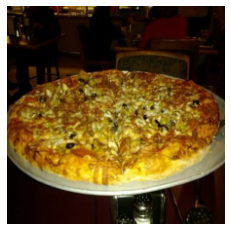

In [ ]:
# Loading the first image from the first test batch
image = next(iter(test_dl))[0][0]

# Plotting the Image
plt.imshow(image.permute(1, 2, 0))
plt.axis(False);

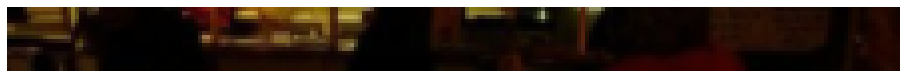

In [ ]:
# Visualizing the top row of patched pixels
plt.figure(figsize=(PATCH_SIZE, PATCH_SIZE))
plt.imshow(image.permute(1, 2, 0)[:PATCH_SIZE, :, :])
plt.axis(False);

Number of Patches in first Row: 14
Patch Size: 16


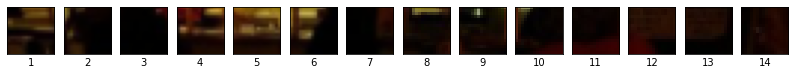

In [ ]:
# Let's turn this top row into patches
IMG_SIZE = 224
TOP_ROW_N_PATCHES = int(IMG_SIZE / PATCH_SIZE)

assert (IMG_SIZE % PATCH_SIZE == 0), "Image must be divisible by patch size"

print(f"Number of Patches in first Row: {TOP_ROW_N_PATCHES}\nPatch Size: {PATCH_SIZE}")

# Create a series of subplots
fig, ax = plt.subplots(nrows=1,
                      ncols=TOP_ROW_N_PATCHES,
                      figsize=(TOP_ROW_N_PATCHES, TOP_ROW_N_PATCHES),
                      sharex=True,
                      sharey=True)

for i, patch in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    ax[i].imshow(image.permute(1, 2, 0)[:PATCH_SIZE, patch:patch+PATCH_SIZE, :])
    ax[i].set_xlabel(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Number of patches per row: 14        
Number of patches per column: 14        
Total patches: 196        
Patch size: 16 pixels x 16 pixels


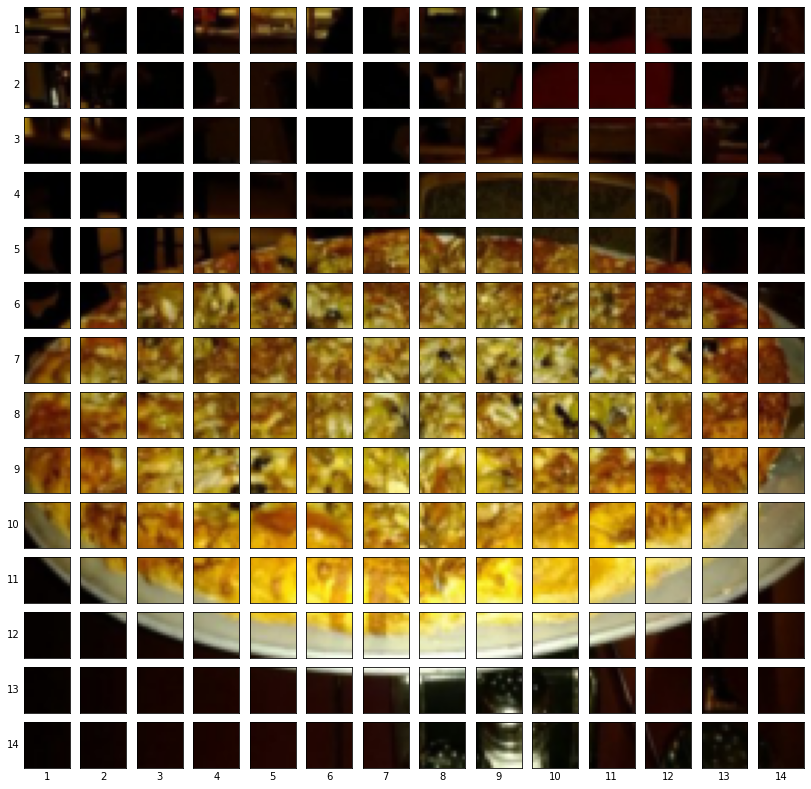

In [ ]:
# Let's to the same think for every row
IMG_SIZE = 224
NUM_PATCHES = int(IMG_SIZE / PATCH_SIZE)

assert (IMG_SIZE % PATCH_SIZE == 0), "Image must be divisible by patch size"

print(f"Number of patches per row: {NUM_PATCHES}\
        \nNumber of patches per column: {NUM_PATCHES}\
        \nTotal patches: {NUM_PATCHES*NUM_PATCHES}\
        \nPatch size: {PATCH_SIZE} pixels x {PATCH_SIZE} pixels")

# Setting the Subplots
fig, ax = plt.subplots(nrows=NUM_PATCHES,
                       ncols=NUM_PATCHES,
                       figsize=(NUM_PATCHES, NUM_PATCHES),
                       sharex=True,
                       sharey=True)

# Iterate over every Patch
for i, patch_height in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    for j, patch_width in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
        ax[i, j].imshow(image.permute(1, 2, 0)[patch_height:patch_height+PATCH_SIZE, patch_width:patch_width+PATCH_SIZE, :])
        ax[i, j].set_ylabel(i + 1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        ax[i, j].set_xlabel(j + 1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].label_outer()

plt.show()

### Turning Images into Patches (using `nn.Conv2d()`)

To visualize our single image we wrote code to loop through the different height and width dimensions of a single image and plot individual patches. This operation is very similar to the `convolutional operation`

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (`CNN`):
* As an alternative to raw image patches, the input sequence can be formed from **feature maps** of a CNN. In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN **feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.

The **feature map** they're refering to are the weights/activations produced by a convolutional layer passing over a given image.

-

By setting the `kernel_size` and `stride` parameters of a `torch.nn.Conv2d()` layer equal to the **PATCH_SIZE**, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

We'll set `in_channels=3` for the number of color channels in our image and `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size **PATCH_SIZE** x **PATCH_SIZE** x **Colour Channels**=768).

In [ ]:
# Creating the Convolution Layer
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=PATCH_SIZE*PATCH_SIZE*COLOUR_CHANNELS,
                   kernel_size=(PATCH_SIZE, PATCH_SIZE),
                   stride=PATCH_SIZE,
                   padding=0)

In [ ]:
# Passing an image through this layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))

print(image_out_of_conv.squeeze(dim=0).shape) # (`embedding_dim`, `feature_map_height`, `feature_map_width`)

torch.Size([768, 14, 14])


Random Feature Maps Indexes: [6, 100, 738, 162, 245]



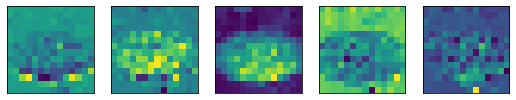

In [ ]:
# Let's visualize some of those feature maps
from random import sample

# Getting the indexes of 5 random numbers from 0 to `embedding_dim`
random_indexes = sample(range(0, 758), k=5)

print(f"Random Feature Maps Indexes: {random_indexes}\n")

# Creating the subplots
fig, ax = plt.subplots(nrows=1,
                       ncols=5,
                       figsize=(9, 9))

for i, ind in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv.squeeze(dim=0)[ind, :, :]
    ax[i].imshow(image_conv_feature_map.detach().numpy())
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

The weights of the Convolutional Layer are random that's why we see those images. Because we are talking about a CNN Layer, that means that those parameters are learnable and the NN will figure those values by itself.

### Flattening the Patch Embedding (using `nn.Flatten()`)

We've turned our image into patch embeddings but they're still in 2D format.

The desried output (1D sequence of flattened 2D patches) is:
- (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

In [ ]:
# The current output shape is:
print(image_out_of_conv.squeeze(dim=0).shape) # (768=P^2*C, 14, 14), 14*14 = The total Patches

torch.Size([768, 14, 14])


So we need to `Flatten` the spatial dimensions of the **feature map** output, which in our case is the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`.

In [ ]:
# Creating a Flatten layer
flatten = nn.Flatten(start_dim=1, # Flatten `feature_map_height` that is the 2nd Dimension
                     end_dim=2)   # Flatten `feature_map_width` that is the 3nd Dimension

# Flattening the output:
image_out_of_conv_flattened = flatten(image_out_of_conv.squeeze(dim=0)) # `squeeze(dim=0)` for removing the `batch size`

print(image_out_of_conv_flattened.shape)

torch.Size([768, 196])


In [ ]:
# Fixing the Shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(1, 0)

print(image_out_of_conv_flattened_reshaped.shape)

torch.Size([196, 768])


In [ ]:
# Visualize the flatten output
single_flattened_feature_map = image_out_of_conv_flattened_reshaped.unsqueeze(dim=0)[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False);

# `unsqueeze(dim=0)` for giving one more dimension in order to plot the flattened map 

**Note**: The original Transformer architecture was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in the way it is. We're essentially taking a 2D image and formatting it so it appears as a 1D sequence of text.

### Turning the ViT Patch Embedding Layer into a PyTorch Module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d().
4. Create a layer to flatten the patch feature maps into a single dimension.
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

In [ ]:
class PatchEmbedded(nn.Module):
    def __init__(self, input_channels=COLOUR_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=PATCH_SIZE**2 * COLOUR_CHANNELS):
        super().__init__()

        self.patch_size = patch_size

        # Creating the layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=input_channels,
                                out_channels=embedding_dim,
                                kernel_size=(PATCH_SIZE, PATCH_SIZE),
                                stride=PATCH_SIZE,
                                padding=0)
        # Creating the layer to flatten the patch feature maps into one Dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape (it's the image size: W or H)
        image_resolution = x.shape[-1]
        assert (image_resolution % self.patch_size == 0), f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)

        # Adjust the shape (now it has (`batch_size`, `embedding_dim`, `patch_size*patch_size`)),
        # We want (`batch_size`, `patch_size*patch_size`, `embedding_dim`) so
        return x_flatten.permute(0, 2, 1)

In [ ]:
# Trying the class in the image
patchify = PatchEmbedded()

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Ouput image shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Ouput image shape: torch.Size([1, 196, 768])


### Returning a Summary of the Patch Embedder Class

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedded(), 
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedded (PatchEmbedded)            [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the Class Token Embedding

We've made the image **patch embedding**, time to get to work on the **class token embedding** ($\mathbf{x}_\text {class }$ from equation 1).

-

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description:
* Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).

**Note**: [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a [ class ] token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.


To `prepend a learnable embedding to the sequence of embedded patches` we need to create a learnable embedding in the shape of the embedding_dimension ($D$) and then add it to the `number_of_patches` dimension.

Let's create a learnable embedding for the `class token`.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a torch.ones() tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with requires_grad=True.

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Creating the class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

print(class_token.shape)

torch.Size([1, 1, 768])


**Note**: Here we're only creating the class token embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the class token embedding with `torch.randn()` (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

In [ ]:
# To construct the first equation we are going to use `torch.hstack()`
patch_embedded_image_with_class_embedding = torch.hstack((class_token, patch_embedded_image))

print(patch_embedded_image_with_class_embedding.shape) # (`batch_size`, `number_of_patches` + `class_token`, `embedding dim`)

torch.Size([1, 197, 768])


### Creating the Position Embedding

WQe've got the class token embedding and the patch embedding, now how might we create the position embedding? ($\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding")

According to the paper:
* Position embeddings are added to the patch embeddings to retain `positional information`. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By `retain positional information` the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.



Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

\begin{aligned}
\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} & &
\end{aligned}

-

* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the patch embeddings, different values for $D$ can be found in Table 1 (embedding dimension).

In [ ]:
# We have calculated the number of patches: `n_of_patches`
print(n_of_patches)

# We have calculated the embedded dimensions: `embedding_dimension`
print(embedding_dimension)

# Creating the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(batch_size, n_of_patches + 1, embedding_dimension), requires_grad=True)

print(position_embedding.shape)

196
768
torch.Size([1, 197, 768])


Let's add the `position embeddings` to our sequence of patch embeddings with a prepended class token.

In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding.shape) # (`batch_size`, `number_of_patches` + `class_token`, `embedding dim`)

torch.Size([1, 197, 768])


### Converting the First Equation into Code (all in one)


In [ ]:
# 0. Printint the shape of original image Tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")

colour_channels, height, width = image.shape[0], image.shape[1], image.shape[2]

Image tensor shape: torch.Size([3, 224, 224])


In [ ]:
# 1. Adding batch dimension to the Tensor
batched_image = image.unsqueeze(dim=0)

print(f"Input Image with Batch Dimension Shape: {batched_image.shape}")

Input Image with Batch Dimension Shape: torch.Size([1, 3, 224, 224])


In [ ]:
# 2. Setting the Patch, Embedding Dimension Size and Number of Patches
patch_size = 16
n_patches = (height * width) // (patch_size ** 2)
embedding_dim = (patch_size ** 2) * colour_channels

print(f"Patch Size: {patch_size}")
print(f"Number of Patches: {n_patches}")
print(f"Number of Embedding Dimensions: {embedding_dim}")

Patch Size: 16
Number of Patches: 196
Number of Embedding Dimensions: 768


In [ ]:
# 3. Creating Patch Embedding Layer and Passing the Batched Image through it
patch_embedding_layer = PatchEmbedded(input_channels=3,
                                      patch_size=patch_size,
                                      embedding_dim=embedding_dim)
patch_embedding = patch_embedding_layer(batched_image)

print(f"Patching Embedding Shape: {patch_embedding.shape}")

Patching Embedding Shape: torch.Size([1, 196, 768])


In [ ]:
# 4. Creating the Class Tocken Embedding and Adding it to the Patch Embedding
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad=True)
patch_embedding_class_token = torch.hstack((class_token, patch_embedding))

print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

Patch embedding with class token shape: torch.Size([1, 197, 768])


In [ ]:
# 5. Creating the Position Embedding and Adding it to the Tocken Patch Embedding
position_embedding = nn.Parameter(torch.randn(batch_size, n_patches+1, embedding_dim), requires_grad=True)
patch_and_position_embedding = patch_embedding_class_token + position_embedding

print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Patch and position embedding shape: torch.Size([1, 197, 768])


The hole process is described by the following animation:

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif">

## Equation 2: Multi-Head Attention (MSA)

To start, we'll break down the `Transformer Encoder` section into two parts, one for equation 2 and the other for equation 3.

The second equation is:
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}

This indicates a Multi-Head Attention (`MSA`) layer wrapped in a LayerNorm (`LN`) layer with a `residual connection` (the input to the layer gets added to the output of the layer).

This equation is reffered as an `MSA Block`.

To replicate these layers and residual connection with **PyTorch Code** we can use:
* Multi-Head Self Attention (MSA) - `torch.nn.MultiheadAttention()`.
* Norm (LN or LayerNorm) - `torch.nn.LayerNorm()`.
* Residual connection - add the input to output (we'll see this later on when we create the full Transformer Encoder block).

### The LayerNorm (LN) Layer

**Layer Normalization** as the name suggest normalizes an input over the last dimension.

PyTorch's `torch.nn.LayerNorm()` main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be $D$ or 768 for ViT-Base).

* Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

We can think of any kind of _normalization_ as "getting the data into a similar format" or "getting data samples into a similar distribution".

Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths. `Normalization` is the equivalent of making all the stairs the same height and length except the stairs are your data samples.


### The Multi-Head Self Attention (MSA) Layer

Originally designed for text inputs, the original **self-attention** mechanism takes a sequence of words and then calculates which word should pay more **attention** to another word.

Since our input is a sequence of image patches rather than words, **self-attention** and in turn **multi-head attention** will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

As input to the MSA Layer we can see 3 arrows:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" width=1000>

This is known as `query`, `key`, `value` input or qkv for short which is fundamental to the self-attention mechanism.

In our case, the `triple embedding` input will be three versions of the output of the **Norm Layer**, one for query, key and value.

We can implement the `MSA Layer` in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* `batch_first` - does our batch dimension come first? (yes it does)

In [ ]:
# Creating the `MSA Block`
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
        super().__init__()

        # Creating the LN Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Creating the MSA Layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attn_dropout,
                                                         batch_first=True)
        
    def forward(self, x):
        # Passing it through the Norm Layer
        x = self.layer_norm(x)

        # Passing the Normalized input into the MSA Layer
        attn_output, _ = self.multihead_attention(query=x,
                                                  key=x,
                                                  value=x,
                                                  need_weights=False) # Do we need the weights or just the layer outputs?
        return attn_output

**Note**: Unlike Figure 1, our MultiheadSelfAttentionBlock doesn't include a skip or residual connection ("$\mathbf{z}_{\ell-1}^{\prime}$" in equation 2), we'll include this when we create the entire Transformer Encoder later on.

In [ ]:
# Creating a MSA Layer Instance:
multihead_self_attention_block = MultiHeadSelfAttentionBlock() # Parameters from `Table 1`

# Passing the Embedding Image into the Layer
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Equation 3: Multilayer Perceptron (MLP)

The third equation goes as follows:
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}

Here MLP stands for `multilayer perceptron` and LN stands for `layer normalization` (as discussed above).

This equation is reffered as `MLP Block`.

### The MLP layer(s)

The term `MLP` is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:
* linear layer -> non-linear layer -> linear layer -> non-linear layer

The **MLP** contains two layers with a `GELU` non-linearity.

Where "two layers" refers to linear layers (torch.nn.Linear() in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function (torch.nn.GELU() in PyTorch).

**Note**: A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a _dense layer_ or _feedforward layer_. Some papers even use all three terms to describe the same thing (as in the ViT paper).

A detail about the `MLP Block` is that every linear layer (or dense layer) has a dropout layer (`torch.nn.Dropout()` in PyTorch).

* The value of which can be found in Table 3 of the ViT paper (for ViT-Base, dropout=0.1).

In [ ]:
# Creating the `MLP Block`
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1):
        super().__init__()

        # Creating a LN Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Creating the MLP Layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

**Note**: Unlike Figure 1, our MLPBlock() doesn't include a skip or residual connection ("$\mathbf{z}_{\ell}^{\prime}$" in equation 3), we'll include this when we create the entire Transformer encoder later on.

In [ ]:
# Creating an `MLP Block` Instance
mlp_block = MLPBlock()

# Passing the output of the `MSA Block` into the MLP
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Creating the Transformer Encoder

Time to stack together our `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the `Transformer Encoder` of the ViT architecture.

In deep learning, an **encoder** or **auto encoder** generally refers to a stack of layers that **encodes** an input (turns it into some form of numerical representation).

As the paper informs:
* The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), ware achieved by adding a layer(s) input to its subsequent output.

In the case of the **ViT architecture**, the residual connection means the input of the `MSA block` is added back to the output of the `MSA block` before it passes to the `MLP block`.

What does this do?
* One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

**Note**: The iconic computer vision architecture `ResNet` is named so because of the introduction of residual connections. You can find many pretrained versions of ResNet architectures in `torchvision.models`.

In [ ]:
# Creating the Encoder Transformer
class EncoderTransformetBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0):
        super().__init__()

        # Creating the `MSA Block`
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)

        # Creating the `MLP Block`
        self.mlp_block = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

    def forward(self, x):
        # Creating the Residual Connection for `MSA Block`
        x = self.msa_block(x) + x

        # Creating the Residual Connection for `MLP Block`
        return (self.mlp_block(x) + x)

**Note**: Table 1 from the ViT paper has a `Layers` column. This refers to the number of Transformer Encoder blocks in the specific ViT architecure.

In our case, for _ViT-Base_, we'll be stacking together 12 of these Transformer Encoder blocks to form the backbone of our architecture.

In [ ]:
# Summarizing the model
transformer_encoding_block = EncoderTransformetBlock()

summary(transformer_encoding_block,
        input_size=(1, 197, 768), # (`batch_size`, `num_patches`, `embedding_dimension`)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
EncoderTransformetBlock (EncoderTransformetBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

**Note**: Just because our input to the Transformer Encoder block has the same shape at the output of the block doesn't mean the values weren't manipulated, the whole goal of the Transformer Encoder block (and stacking them together) is to learn a deep representation of the input using the various layers in between.

## Creating the Transformer Encoder using Pytorch `nn.TransformerEncoderLayer()`

In [ ]:
# Creating the same `Transformer Encoder Block` as above
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,          # Hidden Size D from `Table 1`
                                                             nhead=12,             # Heads from `Table 1`
                                                             dim_feedforward=3072, # MLP Size from `Table 1`
                                                             dropout=0.1,          # Amount of Dropout from `Table 3`
                                                             activation="gelu",    # Activation Function
                                                             batch_first=True,     # Do our batches come first?
                                                             norm_first=True)      # Normalize first or after MSA/MLP layers?

In [ ]:
# Get the `summary` of that object
summary(torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (`batch_size`, `num_patches`, `embedding_dimension`)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Finally, since the **ViT architecture** uses several `Transformer Layers` stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with `torch.nn.TransformerEncoder(encoder_layer, num_layers)` where:
* `encoder_layer` - The target Transformer Encoder layer created with **torch.nn.TransformerEncoderLayer()**.
* `num_layers` - The number of Transformer Encoder layers to stack together.

## Putting it all Together to Create ViT

We're going to combine all of the blocks we've created to replicate the full ViT architecture.

From the patch and positional embedding to the Transformer Encoder(s) to the `MLP Head`.

The `MLP Head`, otherwise the equation 4 states:
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}

All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have.

In [ ]:
# Creating the `ViT Model Class`
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000,
                 ):
        super().__init__()

        # 1. Making `image_size` is Divisble by `patch_size`
        assert (img_size % patch_size == 0), f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 2. Calculating the Number of Patches
        self.num_patches = (img_size ** 2) // (patch_size ** 2)

        # 3. Creating a Learnable Class and Position Embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

        # 4. Creating a Patch Embedding Layer
        self.patch_embedding = PatchEmbedded(input_channels=in_channels,
                                             patch_size=patch_size,
                                             embedding_dim=embedding_dim)
        
        # 5. Creating an Embedding Dropout Layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 6. Creating the Transformer Encoder Blocks
        self.transformer_encoder_blocks = nn.Sequential(
            *[EncoderTransformetBlock(embedding_dim=embedding_dim,
                                      num_heads=num_heads,
                                      mlp_size=mlp_size,
                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )

        # 7. Creating a Classifier Head (equation 4)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        # 1. Getting Batch Size
        batch_size = x.shape[0]

        # 2. Creating the Class Token Embedding
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        """
        torch.Tensor.expand: Returns a new view of the self tensor with singleton dimensions expanded to a larger size.

        In that case it expands the resulted Tensor from `class_embedding` to (`batch_size`, x, y) from (1, x, y).
        Passing -1 as the size for a dimension means not changing the size of that dimension.
        """

        # 3. Creating Path Embedding
        x = self.patch_embedding(x)

        # 4. Concatinating Class and Patch Embedding (equation 1)
        x = torch.hstack((class_token, x))

        # 5. Adding Position Embedding to Patch Embedding (equation 1)
        x = self.position_embedding + x

        # 6. Running Embedding Dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 7. Passing the Embedding through the Transformer Encoding Blocks (equation 2, 3)
        x = self.transformer_encoder_blocks(x)

        # 8. Putin 0th index Logit through Classifier (equation 4)
        return self.classifier(x[:, 0])

## Initializing Model Instance

In [ ]:
model = ViT(num_classes=len(class_names))

summary(model,
        input_size=(32, 3, 224, 224), # (`batch_size`, `colour channels`, `height`, `width`)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedded (patch_embedding)                                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder_blocks)                         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─EncoderTransformetBlock (0)                           

The number is very close to PyTorch's pretrained ViT-Base with patch size 16 at `torch.vision.models.vit_b_16()` with 86,567,656 total parameters (though this number of parameters is for the 1000 classes in ImageNet).

## Passing Dummy Data to the Model

In [ ]:
random_image_tensor = torch.randn(1, 3, 224, 224)

model.eval()
with torch.inference_mode():
    logits = model(random_image_tensor.to(device))

print(logits)

tensor([[-0.2954, -0.1763,  0.0910]])


## Setting Optimizer

The paper states:
* Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9$, $\beta_{2}=0.999$, a batch size of $4096$ and apply a high weight decay of $0.3$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9$, $\beta_{2}=0.999$, these are the default values for the betas parameter in `torch.optim.Adam(betas=(0.9, 0.999))`.

They also state the use of weight decay (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the weight_decay parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the `learning rate` of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

In [ ]:
opt = optim.Adam(params=model.parameters(),
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 weight_decay=0.3)

## Training the Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()

results = engine.fit(model=model,
        epochs=10,
        train_dl=train_dl,
        valid_dl=test_dl,
        loss_fn=loss_fn,
        eval_metric=engine.accuracy_fn,
        optim=opt)

## What Went Wrong?

There are several things that led to that performance:
* Number of training images: too small
* Epochs: too few
* Batch size: too small
* Learning rate warmup: none

Good news is, there are many pretrained ViT models (using vast amounts of data) available online.

## Getting a Pretrained ViT Model and Creating a Feature Extractor

In [ ]:
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# Setting up a ViT Model Instance
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freezing the Base Parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Changing the Classifier Head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
# Getting a Summary of that Model
summary(pretrained_vit)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

## Preparing the Dataset to Train this Model

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dl_pre, test_dl_pre, class_names = data_setup.create_dataloaders(train_dir=train_path, 
                                                                       test_dir=test_path,
                                                                       train_transform=pretrained_vit_transforms,
                                                                       test_transform=pretrained_vit_transforms,
                                                                       batch_size=32)
print(len(train_dl_pre), len(test_dl_pre))
print(class_names)

8 3
['pizza', 'steak', 'sushi']


## Training the Pretrained Model

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
results_pre = engine.fit(model=pretrained_vit,
                         epochs=10,
                         train_dl=train_dl_pre,
                         valid_dl=test_dl_pre,
                         loss_fn=loss_fn,
                         eval_metric=engine.accuracy_fn,
                         optim=optimizer,
                         n_train_batch_prints=5)

Starting Process...


  0%|          | 0/10 [00:00<?, ?it/s]

	Looked at 32/256 training samples...
	Looked at 64/256 training samples...
	Looked at 96/256 training samples...
	Looked at 128/256 training samples...
	Looked at 160/256 training samples...
	Looked at 192/256 training samples...
	Looked at 224/256 training samples...
	Looked at 256/256 training samples...
-----------------------------------------------------------------------------------------------------------
-> Epoch: 1 | Train Loss: 0.7702 | Train Accuracy: 76.17% | Test Loss: 0.5641 | Test Evaluation (%): 85.70%
-----------------------------------------------------------------------------------------------------------
	Looked at 32/256 training samples...
	Looked at 64/256 training samples...
	Looked at 96/256 training samples...
	Looked at 128/256 training samples...
	Looked at 160/256 training samples...
	Looked at 192/256 training samples...
	Looked at 224/256 training samples...
	Looked at 256/256 training samples...
----------------------------------------------------------

KeyboardInterrupt: ignored